#INFO-6147 - Capstone Project - Pedro Aguiar

The structure of the code created for this project has been explaned through the following topics:

**Imported Libraries:**

The imports begin by importing basic Python libraries to support deep learning and data visualization. Basic imports include PyTorch for neural network construction and training (torch, nn, optim), TorchVision for pretrained models and transforms (models, transforms), NumPy for math, and Matplotlib/Seaborn for plots. Scikit-learn's metrics (classification_report, confusion_matrix) are imported to evaluate model performance. The libraries overall support dataset manipulation, model architecture build, training, and visualization.

**Setting Environment:**

For reproducibility, the code sets random seeds for PyTorch (torch.manual_seed(42)) and NumPy (np.random.seed(42)), ensuring repeated runs provide the same results. The device setup (torch.device) also automatically identifies and uses a GPU if available (cuda:0), defaulting to CPU in the absence of a GPU. This optimizes hardware resource utilization for efficient computation during training.

**Importing Dataset and Creating Data Loaders:**

The dataset is imported and processed using TorchVision's ImageFolder and custom transformation. Training images are augmented using data augmentation techniques to improve generalization, while validation images are simply resized and normalized. The dataset is split so that some portion is focused on specific plant disease classes. The DataLoader class then batches these images (batch_size=32) for effective training and validation, with shuffling enabled for the training set to permit randomness.

**Model Comparison Framework:**

The core of the experiment is the initialize_model, train_model, and evaluate_model functions. The initialize_model function loads pre-trained architectures (ResNet or VGG variants) and replaces their last fully connected layers to match the number of target classes (num_classes). Pretrained layers freezing (feature_extract=True) supports effective transfer learning. The train_model function takes care of the training loop, tracking loss and accuracy by epochs, implementing early stopping by validation accuracy, and saving best model weights. The evaluate_model function returns a classification report and confusion matrix to gauge performance.

**Model Comparison Execution:**

Six models (resnet18, resnet34, resnet50, vgg11, vgg13, vgg16) are trained sequentially on the same hyperparameters (optimizer, learning rate, epochs). Training history and best validation accuracy for every model are stored in a dictionary (results). Using this uniform approach ensures comparison in a similar manner across architectures. The loop prints epoch-wise loss and accuracy for every model and performance on the validation set after training.

**Performance Comparison and Visualization:**

Post-training, the code plots each model's validation accuracy and loss curves together for easy comparison. A summary table also lists the highest validation accuracy of each model, noting the top few performers. The visualizations reveal trends, such as whether deeper models perform better than lighter ones or whether VGG variants have longer training times due to more parameters.

**Visualization of Model Predictions:**

To qualitatively measure performance, the visualize_model_predictions function graphically displays a grid of test images with predictions from each model. For each image, the true label is shown with the original image, followed by the prediction of each model. The side-by-side display reveals patterns in misclassifications—for example, if specific models repeatedly misclassify diseases that look alike. A compact version summary (visualize_predictions_compact) displays all predictions for a single image in a single row to avoid redundancy while being understandable. These visualizations bridge the gap between quantitative metrics and daily usability and show how models might act in the real world.


##0. Imported Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

##1. Setting Envirnoment

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##2 . Importing dataset and creating data Loader

In [3]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Selecting classes for manageable comparison
selected_classes = [
    'Apple___Black_rot',
    'Grape___Black_rot',
    'Potato___Late_blight',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot']

# Creating subset dataset
def create_subset_dataset(root_dir, selected_classes, transform=None):
    full_dataset = datasets.ImageFolder(root_dir)
    class_to_idx = {full_dataset.classes[i]: i for i in range(len(full_dataset.classes))}

    selected_indices = []
    for target_class in selected_classes:
        class_idx = class_to_idx[target_class]
        indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == class_idx]
        selected_indices.extend(indices[:500])  # Take max 500 per class

    subset_dataset = torch.utils.data.Subset(full_dataset, selected_indices)
    subset_dataset.dataset.transform = transform
    return subset_dataset

# Creating datasets
data_dir = '/content/drive/MyDrive/Colab Notebooks/plantvillage dataset (1)/color'
train_dataset = create_subset_dataset(data_dir, selected_classes, data_transforms['train'])
val_dataset = create_subset_dataset(data_dir, selected_classes, data_transforms['val'])

# Creating dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Getting class names and number of classes
class_names = selected_classes
num_classes = len(class_names)

##3. Model comparison framework

In [4]:
def initialize_model(model_name, num_classes, feature_extract=True):
    # Resetting the model
    model = None
    # Handling Resnet Models
    if model_name.startswith('resnet'):
      # Initializing selected resnets models for the project
        if model_name == 'resnet18':
            model = models.resnet18(pretrained=True)
        elif model_name == 'resnet34':
            model = models.resnet34(pretrained=True)
        elif model_name == 'resnet50':
            model = models.resnet50(pretrained=True)

      # Freezing all layers if feature extraction mode
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False

      # Replacing the final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    # Handling VGG models
    elif model_name.startswith('vgg'):
      # Initializing selected VGG's models for the project
        if model_name == 'vgg11':
            model = models.vgg11(pretrained=True)
        elif model_name == 'vgg13':
            model = models.vgg13(pretrained=True)
        elif model_name == 'vgg16':
            model = models.vgg16(pretrained=True)

      # Freezing all layers if feature extraction mode
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False

      # Replacing the final classifier layer
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    # Moving model to GPU
    return model.to(device)

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initializing history in order to track the metrics
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')

        # Building training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model for train
                dataloader = train_loader
            else:
                model.eval() # Set model to evaluation
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over date batches
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Enabling gradients only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Settings statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculating epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Updtading the history dictonary and scheduler
            if phase == 'train':
                scheduler.step()
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy of the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Printing training summary
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Code responsable for load the best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, dataloader):
    model.eval() # Set model to evaluation
    all_preds = []
    all_labels = []

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Getting predicted classes

            # Storing predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generating and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

##4. Model comparison execution


 Training - resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Epoch 0/14
train Loss: 0.9999 Acc: 0.6852
val Loss: 0.4742 Acc: 0.9132
Epoch 1/14
train Loss: 0.5059 Acc: 0.8800
val Loss: 0.2205 Acc: 0.9732
Epoch 2/14
train Loss: 0.3830 Acc: 0.9048
val Loss: 0.1503 Acc: 0.9780
Epoch 3/14
train Loss: 0.3189 Acc: 0.9220
val Loss: 0.1168 Acc: 0.9824
Epoch 4/14
train Loss: 0.2998 Acc: 0.9144
val Loss: 0.1084 Acc: 0.9856
Epoch 5/14
train Loss: 0.2783 Acc: 0.9188
val Loss: 0.0931 Acc: 0.9860
Epoch 6/14
train Loss: 0.2441 Acc: 0.9364
val Loss: 0.0804 Acc: 0.9860
Epoch 7/14
train Loss: 0.2317 Acc: 0.9336
val Loss: 0.0855 Acc: 0.9816
Epoch 8/14
train Loss: 0.2230 Acc: 0.9376
val Loss: 0.0735 Acc: 0.9880
Epoch 9/14
train Loss: 0.2286 Acc: 0.9376
val Loss: 0.0849 Acc: 0.9832
Epoch 10/14
train Loss: 0.2299 Acc: 0.9312
val Loss: 0.0832 Acc: 0.9832
Epoch 11/14
train Loss: 0.2189 Acc: 0.9412
val Loss: 0.0751 Acc: 0.9856
Epoch 12/14
train Loss: 0.2114 Acc: 0.9424
val Loss: 0.0736 Acc: 0.9864
Epoch 13/14
train Loss: 0.2130 Acc: 0.9376
val Loss: 0.0776 Acc: 0.9848
Ep

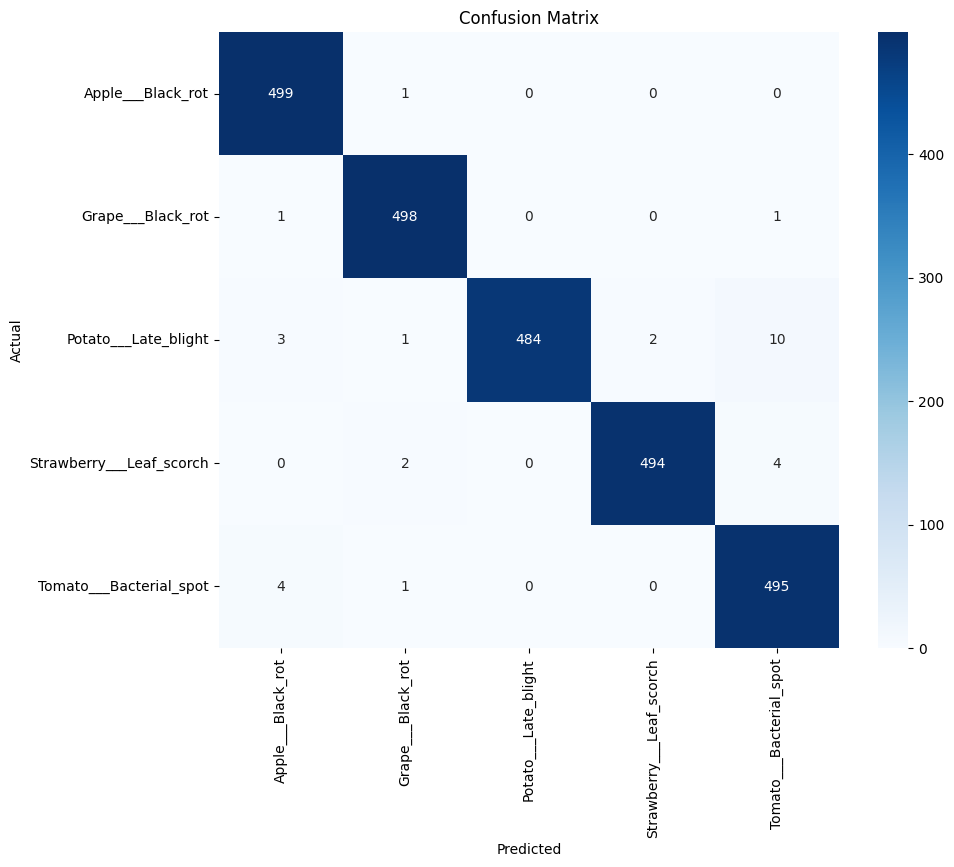


 Training - resnet34


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Epoch 0/14
train Loss: 1.0632 Acc: 0.6540
val Loss: 0.4756 Acc: 0.9252
Epoch 1/14
train Loss: 0.5347 Acc: 0.8644
val Loss: 0.2842 Acc: 0.9464
Epoch 2/14
train Loss: 0.4166 Acc: 0.8880
val Loss: 0.2202 Acc: 0.9624
Epoch 3/14
train Loss: 0.3345 Acc: 0.9152
val Loss: 0.1383 Acc: 0.9848
Epoch 4/14
train Loss: 0.3154 Acc: 0.9112
val Loss: 0.1250 Acc: 0.9812
Epoch 5/14
train Loss: 0.2800 Acc: 0.9200
val Loss: 0.0967 Acc: 0.9888
Epoch 6/14
train Loss: 0.2608 Acc: 0.9272
val Loss: 0.1048 Acc: 0.9792
Epoch 7/14
train Loss: 0.2254 Acc: 0.9372
val Loss: 0.0913 Acc: 0.9832
Epoch 8/14
train Loss: 0.2302 Acc: 0.9348
val Loss: 0.0901 Acc: 0.9868
Epoch 9/14
train Loss: 0.2296 Acc: 0.9348
val Loss: 0.0876 Acc: 0.9868
Epoch 10/14
train Loss: 0.2400 Acc: 0.9296
val Loss: 0.0954 Acc: 0.9844
Epoch 11/14
train Loss: 0.2370 Acc: 0.9328
val Loss: 0.0944 Acc: 0.9848
Epoch 12/14
train Loss: 0.2409 Acc: 0.9344
val Loss: 0.0869 Acc: 0.9872
Epoch 13/14
train Loss: 0.2389 Acc: 0.9284
val Loss: 0.0992 Acc: 0.9816
Ep

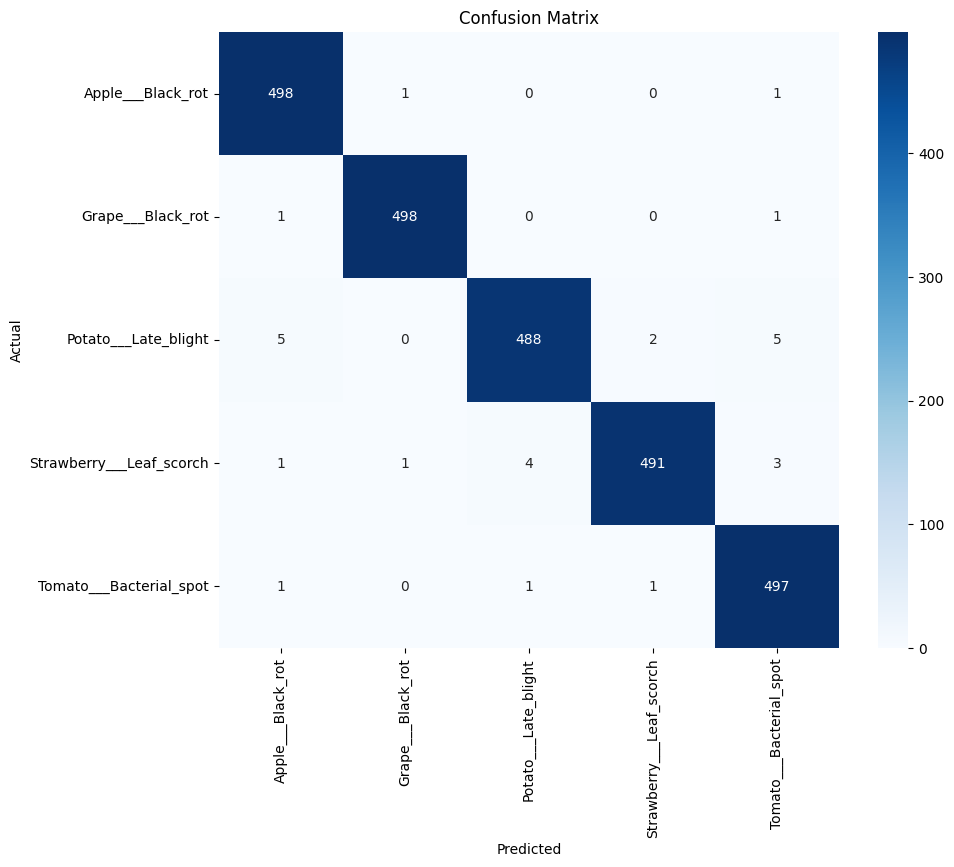


 Training - resnet50


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Epoch 0/14
train Loss: 0.8116 Acc: 0.7660
val Loss: 0.2781 Acc: 0.9564
Epoch 1/14
train Loss: 0.3821 Acc: 0.9016
val Loss: 0.1519 Acc: 0.9756
Epoch 2/14
train Loss: 0.2778 Acc: 0.9276
val Loss: 0.1081 Acc: 0.9812
Epoch 3/14
train Loss: 0.2871 Acc: 0.9116
val Loss: 0.1416 Acc: 0.9596
Epoch 4/14
train Loss: 0.2515 Acc: 0.9228
val Loss: 0.0683 Acc: 0.9864
Epoch 5/14
train Loss: 0.2044 Acc: 0.9376
val Loss: 0.0542 Acc: 0.9916
Epoch 6/14
train Loss: 0.2071 Acc: 0.9368
val Loss: 0.0455 Acc: 0.9916
Epoch 7/14
train Loss: 0.1816 Acc: 0.9400
val Loss: 0.0521 Acc: 0.9888
Epoch 8/14
train Loss: 0.1909 Acc: 0.9468
val Loss: 0.0452 Acc: 0.9916
Epoch 9/14
train Loss: 0.1867 Acc: 0.9436
val Loss: 0.0429 Acc: 0.9932
Epoch 10/14
train Loss: 0.1872 Acc: 0.9428
val Loss: 0.0504 Acc: 0.9884
Epoch 11/14
train Loss: 0.1692 Acc: 0.9512
val Loss: 0.0407 Acc: 0.9928
Epoch 12/14
train Loss: 0.1691 Acc: 0.9508
val Loss: 0.0494 Acc: 0.9884
Epoch 13/14
train Loss: 0.1750 Acc: 0.9420
val Loss: 0.0454 Acc: 0.9904
Ep

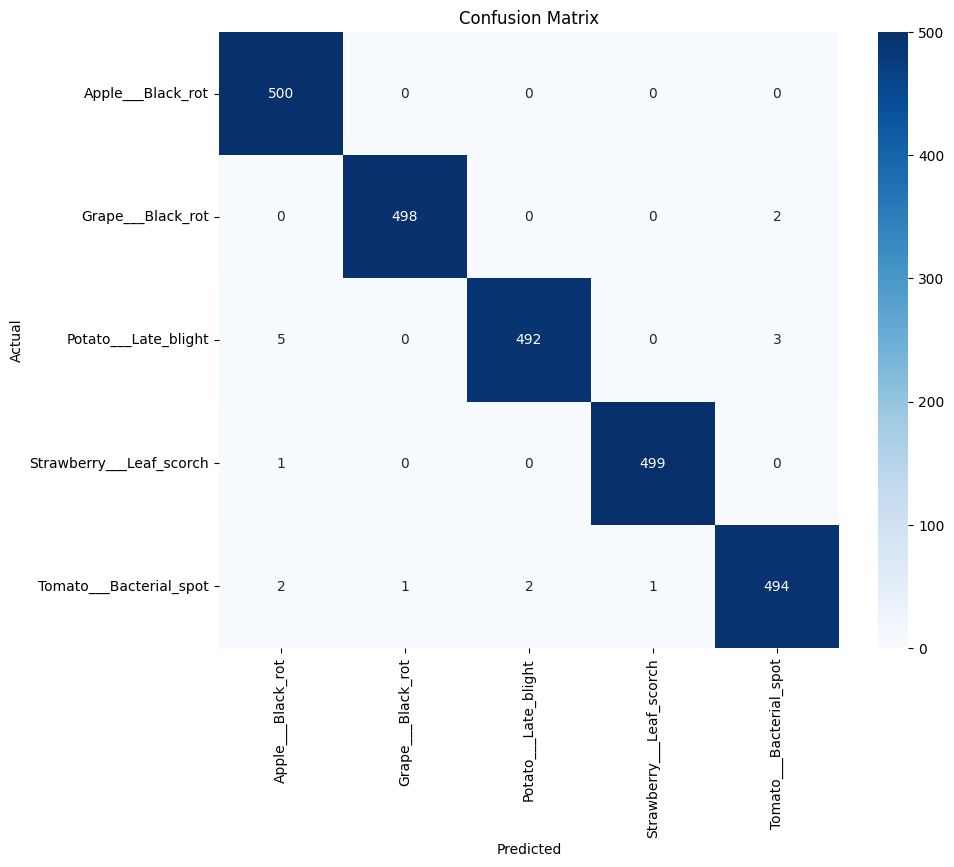


 Training - vgg11


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 163MB/s]


Epoch 0/14
train Loss: 0.6821 Acc: 0.7580
val Loss: 0.2651 Acc: 0.9152
Epoch 1/14
train Loss: 0.4448 Acc: 0.8376
val Loss: 0.2518 Acc: 0.9076
Epoch 2/14
train Loss: 0.3922 Acc: 0.8588
val Loss: 0.1821 Acc: 0.9384
Epoch 3/14
train Loss: 0.3741 Acc: 0.8632
val Loss: 0.1337 Acc: 0.9548
Epoch 4/14
train Loss: 0.3625 Acc: 0.8704
val Loss: 0.1613 Acc: 0.9436
Epoch 5/14
train Loss: 0.3499 Acc: 0.8732
val Loss: 0.1208 Acc: 0.9596
Epoch 6/14
train Loss: 0.3403 Acc: 0.8744
val Loss: 0.1225 Acc: 0.9584
Epoch 7/14
train Loss: 0.3156 Acc: 0.8868
val Loss: 0.1128 Acc: 0.9648
Epoch 8/14
train Loss: 0.3078 Acc: 0.8872
val Loss: 0.1036 Acc: 0.9656
Epoch 9/14
train Loss: 0.3226 Acc: 0.8840
val Loss: 0.1186 Acc: 0.9616
Epoch 10/14
train Loss: 0.2942 Acc: 0.8996
val Loss: 0.1214 Acc: 0.9592
Epoch 11/14
train Loss: 0.2873 Acc: 0.8976
val Loss: 0.1140 Acc: 0.9624
Epoch 12/14
train Loss: 0.3103 Acc: 0.8824
val Loss: 0.1212 Acc: 0.9600
Epoch 13/14
train Loss: 0.2706 Acc: 0.9036
val Loss: 0.1081 Acc: 0.9648
Ep

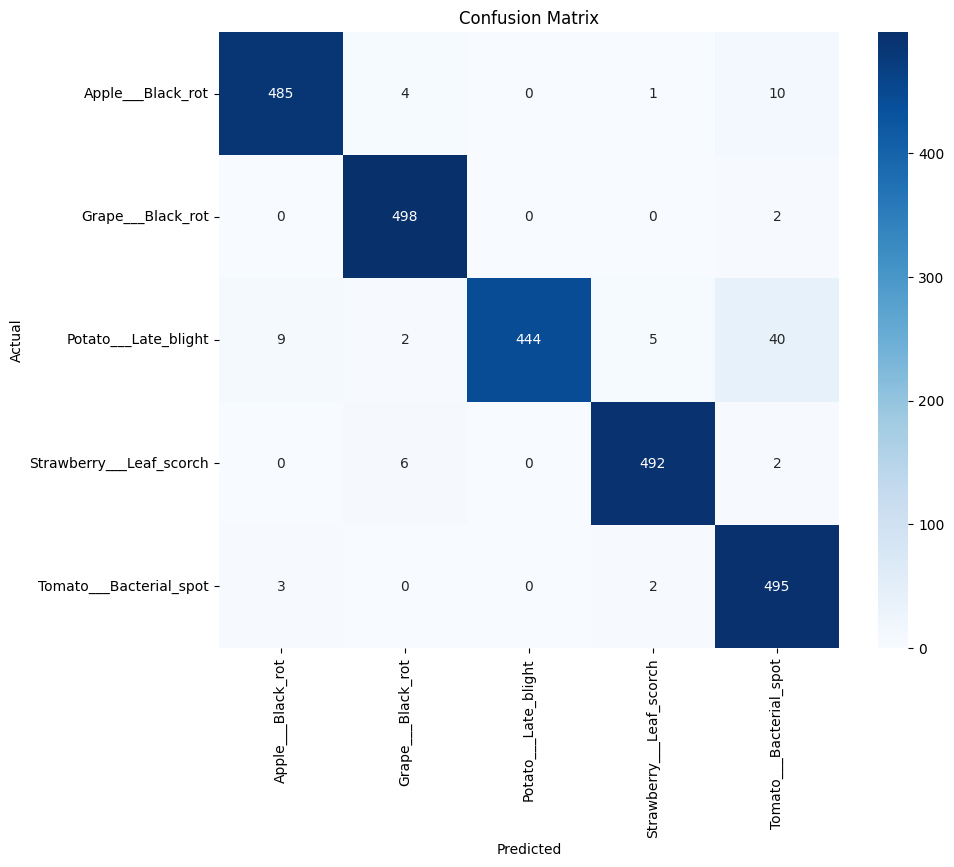


 Training - vgg13


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:05<00:00, 89.6MB/s]


Epoch 0/14
train Loss: 0.6839 Acc: 0.7452
val Loss: 0.2020 Acc: 0.9412
Epoch 1/14
train Loss: 0.4013 Acc: 0.8604
val Loss: 0.1342 Acc: 0.9596
Epoch 2/14
train Loss: 0.3628 Acc: 0.8696
val Loss: 0.1547 Acc: 0.9484
Epoch 3/14
train Loss: 0.3585 Acc: 0.8736
val Loss: 0.0914 Acc: 0.9728
Epoch 4/14
train Loss: 0.3141 Acc: 0.8888
val Loss: 0.0886 Acc: 0.9716
Epoch 5/14
train Loss: 0.3043 Acc: 0.8904
val Loss: 0.0686 Acc: 0.9808
Epoch 6/14
train Loss: 0.2974 Acc: 0.8964
val Loss: 0.0756 Acc: 0.9764
Epoch 7/14
train Loss: 0.2841 Acc: 0.8920
val Loss: 0.0691 Acc: 0.9796
Epoch 8/14
train Loss: 0.2718 Acc: 0.9032
val Loss: 0.0654 Acc: 0.9816
Epoch 9/14
train Loss: 0.2861 Acc: 0.9008
val Loss: 0.0691 Acc: 0.9800
Epoch 10/14
train Loss: 0.2692 Acc: 0.9020
val Loss: 0.0656 Acc: 0.9816
Epoch 11/14
train Loss: 0.2569 Acc: 0.9040
val Loss: 0.0698 Acc: 0.9784
Epoch 12/14
train Loss: 0.2917 Acc: 0.8908
val Loss: 0.0652 Acc: 0.9800
Epoch 13/14
train Loss: 0.2744 Acc: 0.8944
val Loss: 0.0641 Acc: 0.9812
Ep

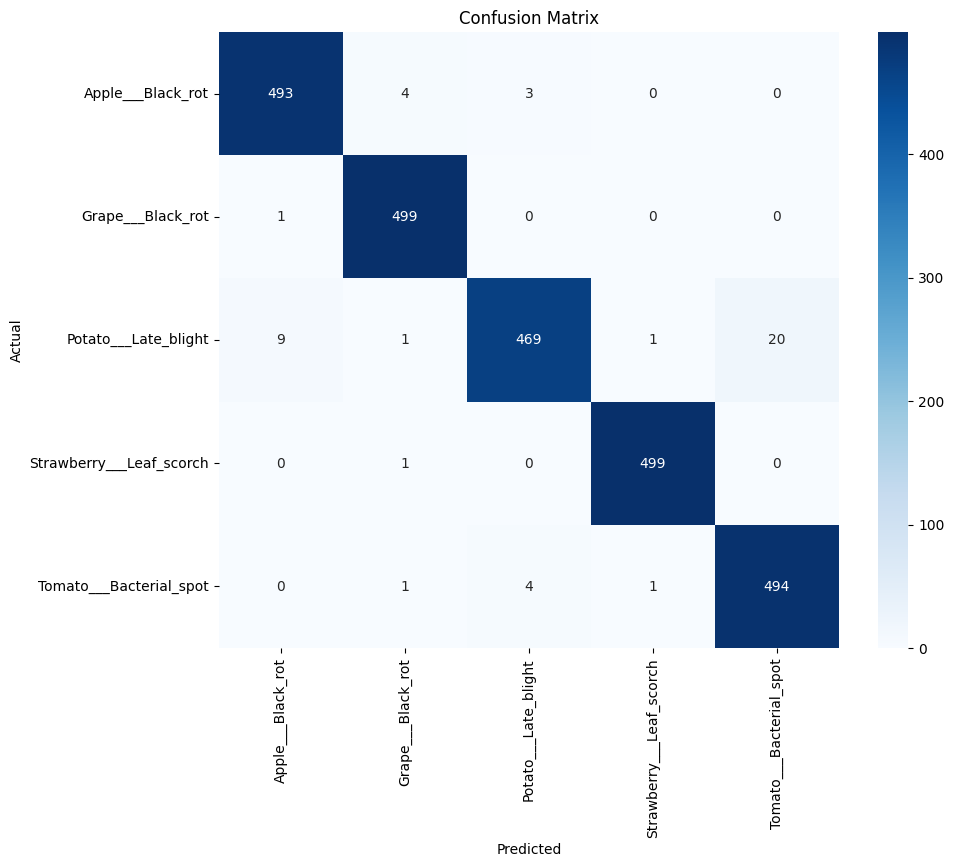


 Training - vgg16


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


Epoch 0/14
train Loss: 0.8224 Acc: 0.6992
val Loss: 0.2889 Acc: 0.9112
Epoch 1/14
train Loss: 0.5365 Acc: 0.8004
val Loss: 0.2516 Acc: 0.9116
Epoch 2/14
train Loss: 0.4725 Acc: 0.8324
val Loss: 0.1975 Acc: 0.9368
Epoch 3/14
train Loss: 0.4363 Acc: 0.8424
val Loss: 0.1696 Acc: 0.9424
Epoch 4/14
train Loss: 0.4148 Acc: 0.8480
val Loss: 0.1870 Acc: 0.9364
Epoch 5/14
train Loss: 0.4219 Acc: 0.8460
val Loss: 0.1928 Acc: 0.9308
Epoch 6/14
train Loss: 0.4125 Acc: 0.8512
val Loss: 0.1518 Acc: 0.9428
Epoch 7/14
train Loss: 0.4027 Acc: 0.8464
val Loss: 0.1399 Acc: 0.9520
Epoch 8/14
train Loss: 0.4006 Acc: 0.8528
val Loss: 0.1423 Acc: 0.9536
Epoch 9/14
train Loss: 0.4031 Acc: 0.8528
val Loss: 0.1366 Acc: 0.9548
Epoch 10/14
train Loss: 0.3751 Acc: 0.8672
val Loss: 0.1461 Acc: 0.9488
Epoch 11/14
train Loss: 0.4064 Acc: 0.8608
val Loss: 0.1441 Acc: 0.9520
Epoch 12/14
train Loss: 0.3829 Acc: 0.8668
val Loss: 0.1390 Acc: 0.9520
Epoch 13/14
train Loss: 0.3808 Acc: 0.8592
val Loss: 0.1409 Acc: 0.9536
Ep

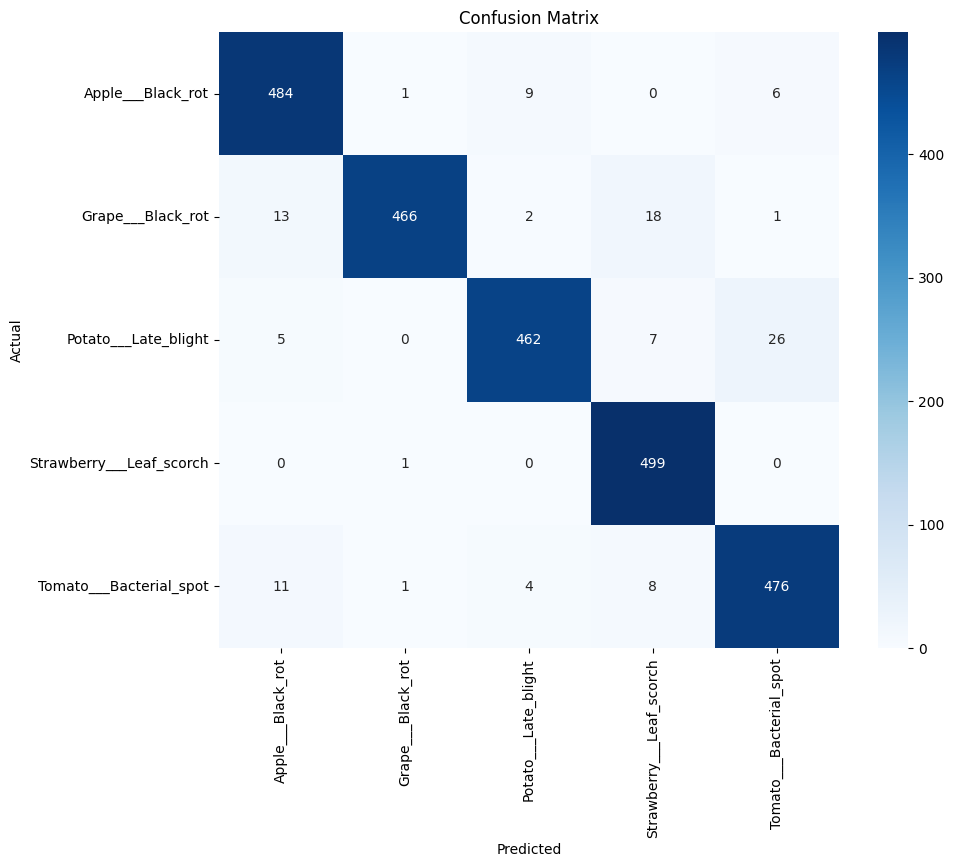

In [5]:
# Models to compare
models_to_compare = ['resnet18', 'resnet34', 'resnet50', 'vgg11', 'vgg13', 'vgg16']
results = {}

for model_name in models_to_compare:
    print(f"\n Training - {model_name}")

    # Initialize the selected model
    model = initialize_model(model_name, num_classes, feature_extract=True)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the selected model
    trained_model, history = train_model(
        model, criterion, optimizer, scheduler, num_epochs=15
    )

    # Store results
    results[model_name] = {
        'model': trained_model,
        'history': history,
        'best_val_acc': max(history['val_acc'])
    }

    # Evaluate on validation set
    print(f"\n Evaluation for {model_name}:")
    evaluate_model(trained_model, val_loader)

##5. Performance comparison and visualization

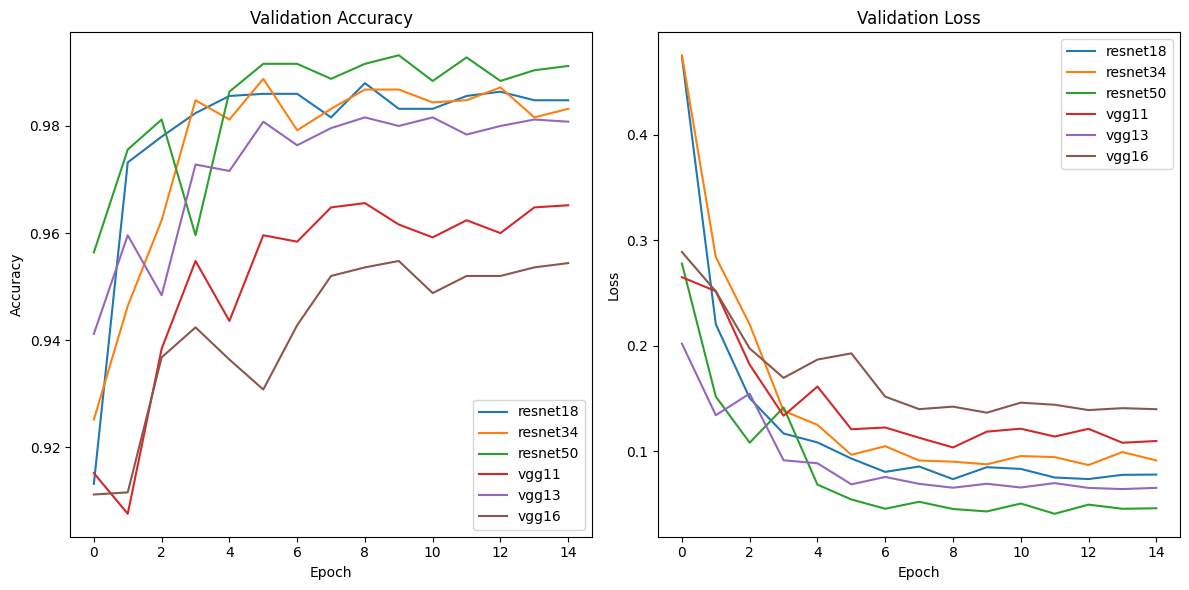


Final Model Comparison
Model      Best Val Accuracy
resnet18   0.9880
resnet34   0.9888
resnet50   0.9932
vgg11      0.9656
vgg13      0.9816
vgg16      0.9548


In [6]:
# Compare model performance
# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for model_name in models_to_compare:
    plt.plot(results[model_name]['history']['val_acc'], label=model_name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
for model_name in models_to_compare:
    plt.plot(results[model_name]['history']['val_loss'], label=model_name)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Model Comparison")
print("{:<10} {:<15}".format('Model', 'Best Val Accuracy'))
for model_name in models_to_compare:
    print("{:<10} {:.4f}".format(model_name, results[model_name]['best_val_acc']))

##6. Visualization of the models predictions

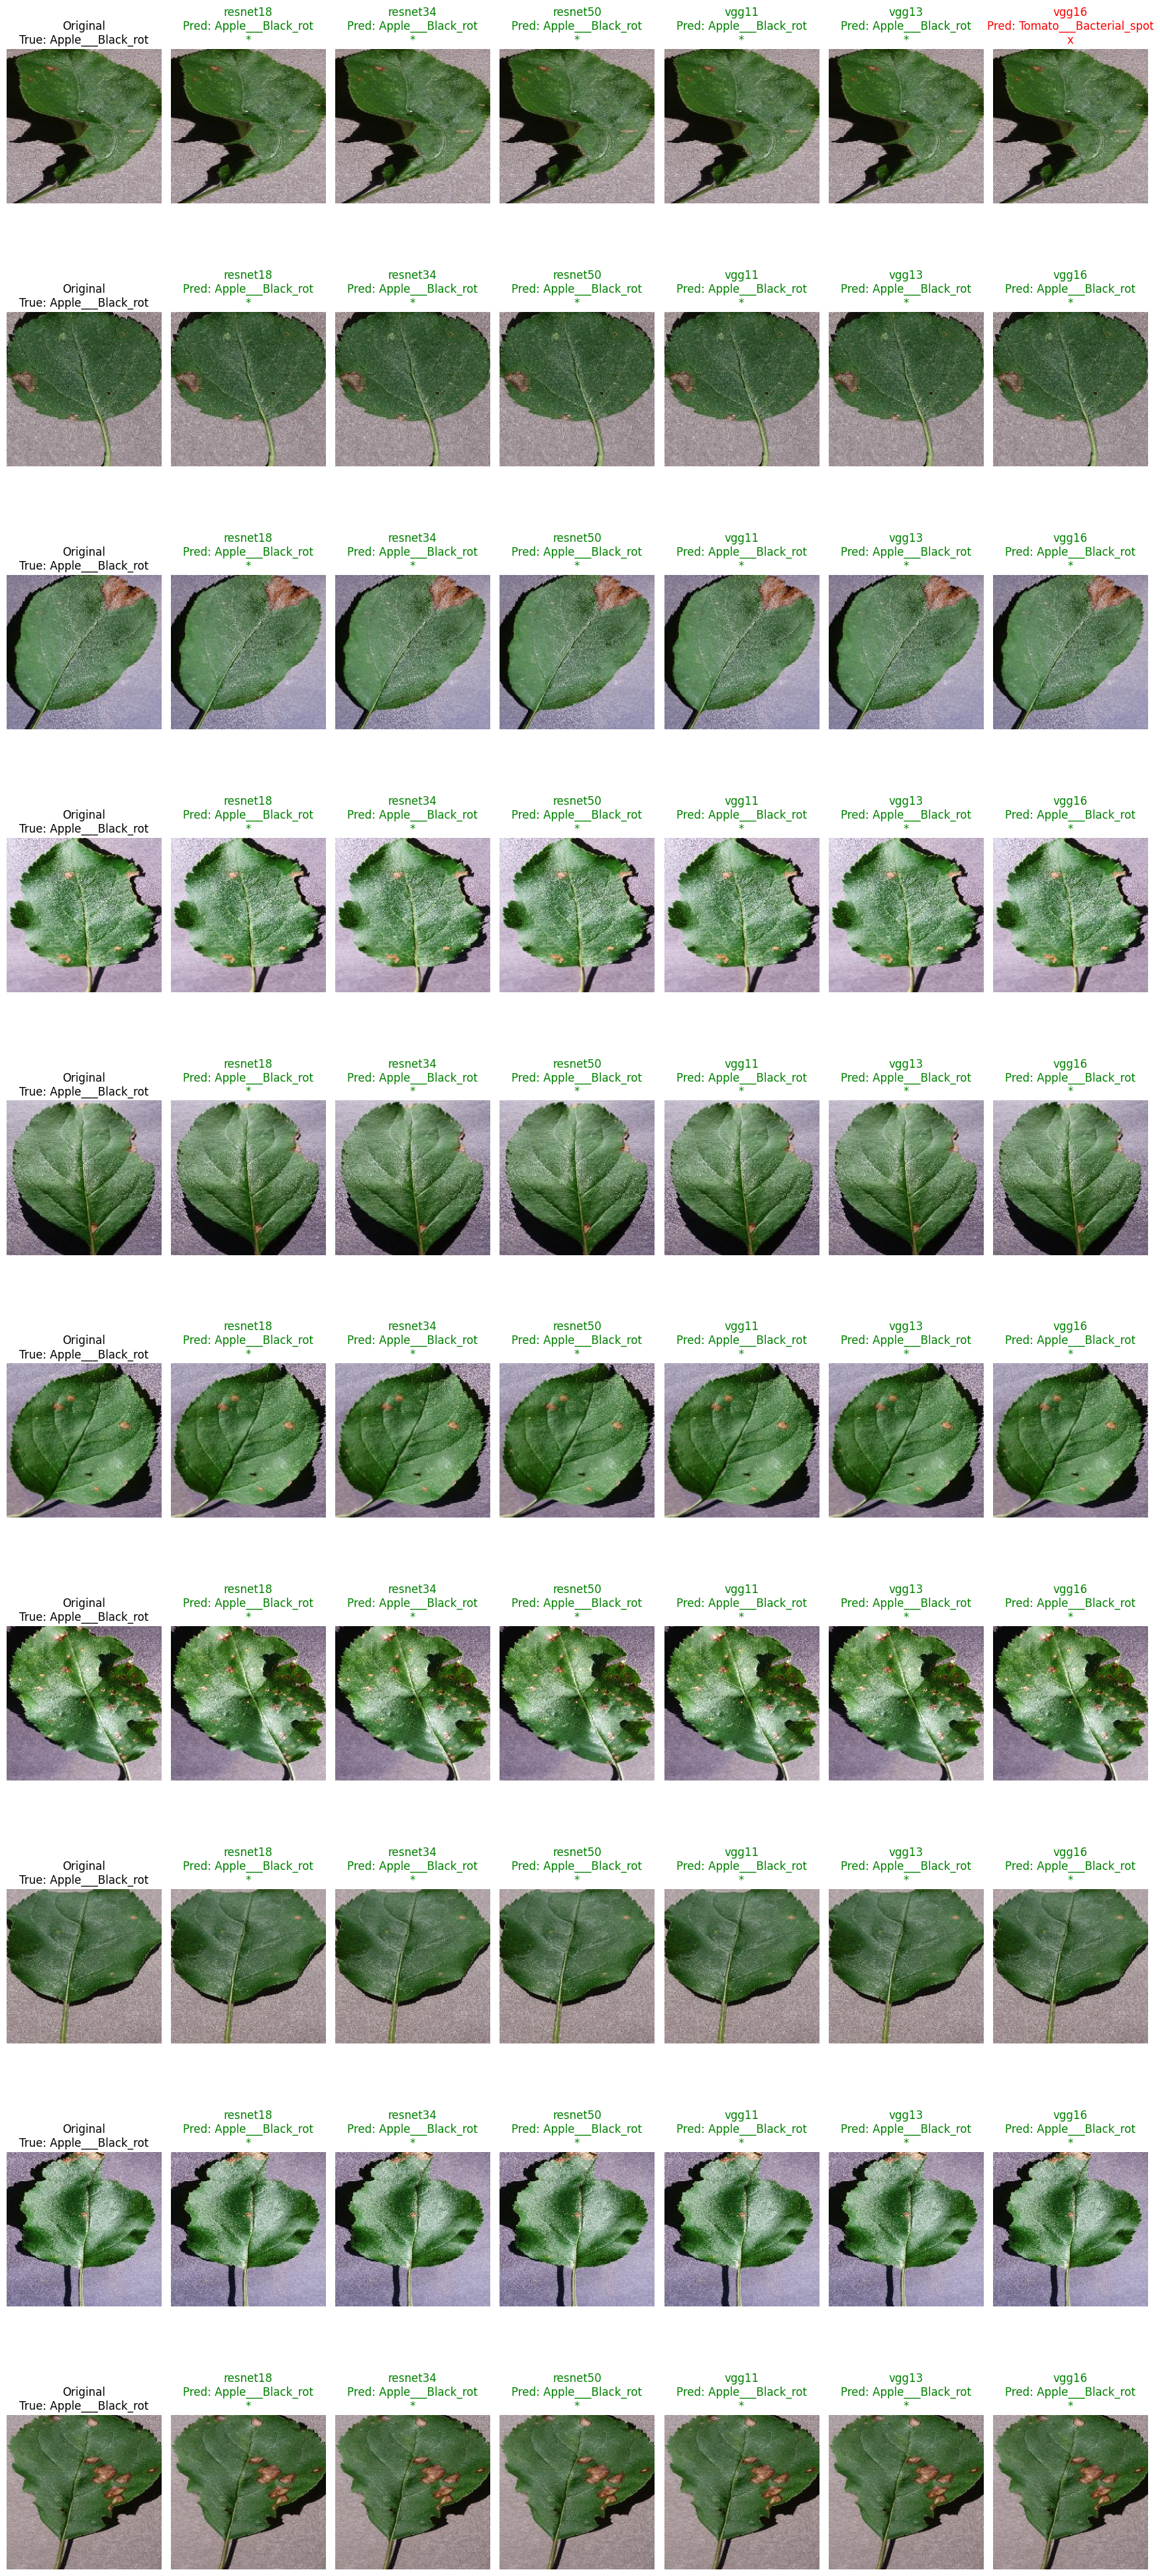

In [7]:
def visualize_model_predictions(results_dict, dataloader, class_names, num_images=10):

    # Get a batch of images from the dataloader
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Select only the specified number of images
    images, labels = images[:num_images], labels[:num_images]

    # Creating figure size based on number of images
    plt.figure(figsize=(20, 4 * num_images))

    # Code responsable for process each image individually
    for idx in range(num_images):
        image = images[idx]
        true_label = labels[idx]

        # Plotting the original image
        ax = plt.subplot(num_images, len(results_dict)+2, idx*(len(results_dict)+2) + 1)
        img = image.numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalizing
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[true_label]}")
        plt.axis('off')

        # For each model in the results dictionary it will make and display predictions
        for model_idx, (model_name, model_data) in enumerate(results_dict.items()):
            model = model_data['model']

            # Get model prediction
            with torch.no_grad():
                output = model(image.unsqueeze(0).to(device))
                _, pred = torch.max(output, 1)
                pred_label = pred.item()
                is_correct = pred_label == true_label.item() # Checking whether the prediction is correct

            # Plotting the prediction result
            ax = plt.subplot(num_images, len(results_dict)+2, idx*(len(results_dict)+2) + model_idx + 2)
            plt.imshow(img)
            plt.title(f"{model_name}\nPred: {class_names[pred_label]}\n{'*' if is_correct else 'x'}",
                     color='green' if is_correct else 'red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_model_predictions(results, val_loader, class_names, num_images=10)